#### Initialization

In [1]:
import findspark
findspark.init( '/usr/local/spark' )
import pyspark
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, DataFrame, functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import FloatType

In [2]:
sc = SparkSession.builder.master( 'local' ).appName( 'Fraud Detection' ).getOrCreate()
print( sc.version )

2.4.0


#### Overview of the Dataset

In [3]:
d = sc.read.csv( 'fraud_dyninno.csv', inferSchema=True, header=True, quote='' )

Number of rows:

In [4]:
nrows = d.count()
print( nrows )

17404


Number of columns:

In [5]:
len( d.columns )

205

Some of the columns:

In [6]:
d.select( 'id', 'date', 'amount', 'term', 'age', 'gender', 'os_name', 'label' ).show( 5 )

+-------+--------------------+------+----+------------------+------+---------+-----+
|     id|                date|amount|term|               age|gender|  os_name|label|
+-------+--------------------+------+----+------------------+------+---------+-----+
|7935509|2019-10-31 18:51:...| 360.0|  30| 25.82340862422998|Female|Windows 7|    0|
|8393870|2019-12-22 13:18:...| 100.0|  30|22.754277891854894|  Male|      iOS|    0|
|7936416|2019-10-31 21:57:...| 360.0|  30| 30.68309377138946|Female|      iOS|    0|
|8038056|2019-11-16 09:46:...| 360.0|  30| 50.38193018480493|Female|Windows 7|    0|
|8065609|2019-11-19 14:25:...| 250.0|  21| 37.23203285420944|Female|  Android|    0|
+-------+--------------------+------+----+------------------+------+---------+-----+
only showing top 5 rows



Quick overview of all the columns:

In [7]:
d.show( 1, vertical=True )

Number of missing values by columns:

In [8]:
d.select( [ f.sum( f.when( f.col( name ).isNull(), 1 ) ).alias( name ) for name in d.columns ] ).show( vertical=True )

Overview of the target variable (label):

In [9]:
d.select( 'label' ).distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



So the target variable is binary.

In [10]:
d.select( 'label' ).summary( 'mean' ).show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|   mean|0.04642610894047346|
+-------+-------------------+



The class is positive (actual fraud) in 4.6% of the cases. The distribution is rather imbalanced.

Financial variables:

"amount": amount of a loan (equivalent in euros)

In [11]:
d.describe( 'amount' ).show()

+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|            17404|
|   mean|236.4410480349345|
| stddev|123.9265367191604|
|    min|             20.0|
|    max|            360.0|
+-------+-----------------+



"term" : term of a loan (in days)

In [12]:
d.describe( 'term' ).show()

+-------+------------------+
|summary|              term|
+-------+------------------+
|  count|             17404|
|   mean|23.023385428637095|
| stddev| 7.937400466031997|
|    min|                 5|
|    max|                30|
+-------+------------------+



expected interest (given that the rate is 0.2% per day):

In [13]:
d = d.withColumn( 'interest', d.amount * 0.002 * d.term )

Additional versions of "amount" and "term" are created, which will be preprocessed and participate in variable selection:

In [14]:
d = d.withColumn( 'amount_prep', d.amount )
d = d.withColumn( 'term_prep', d.term )

#### Transformations of Some Variables

Some numeric application fields should be converted to categorical as they do not imply a natural order:

In [15]:
for name in [ 'cl_marital_status_id', 'cl_employment_type_id', 'cl_employment_area_id' ] :
    d = d.withColumn( name, f.col( name ).cast( 'string' ) )

"ip_country_code":

In [16]:
d.groupBy( 'ip_country_code' ).count().show()

+---------------+-----+
|ip_country_code|count|
+---------------+-----+
|             LT|    3|
|             FI|    1|
|             UA|    1|
|             NL|    3|
|             RU|17367|
|             HK|    1|
|             ID|    1|
|             GB|    2|
|             KZ|    2|
|             BY|    1|
|             MD|    1|
|             DE|    6|
|             ES|    2|
|             IL|    1|
|             US|    4|
|              -|    1|
|             IT|    1|
|             SE|    4|
|             JP|    1|
|             IE|    1|
+---------------+-----+



In [17]:
d = d.withColumn( 'ip_country_code', f.when( d.ip_country_code == 'RU', 0 ).otherwise( 1 ) )

Province:

In [18]:
d = d.withColumn( 'province_mismatch', 
                f.when( ( d.region_app != d.ip_region_name ) & d.region_app.isNotNull() & d.ip_region_name.isNotNull(), 
                1 ).otherwise( 0 ) )

Zip code:

In [19]:
d = d.withColumn( 'zip', f.substring( d.zip, 0, 3 ) )
d = d.withColumn( 'ip_zip_code', f.substring( d.ip_zip_code, 0, 3 ) )

In [20]:
d = d.withColumn( 'zip_mismatch', 
        f.when( ( d.zip != d.ip_zip_code ) & d.zip.isNotNull() & d.ip_zip_code.isNotNull(), 1 ).otherwise( 0 ) )

In [21]:
d.createOrReplaceTempView( 'd' )

"ip_mobile_brand":

In [22]:
q = "\
SELECT ip_mobile_brand, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+---------------+--------+--------------------+
|ip_mobile_brand|count(1)|          avg(label)|
+---------------+--------+--------------------+
|              -|    6414| 0.03445587776738385|
|            MTS|    3323| 0.07132109539572676|
|        MegaFon|    2574| 0.05710955710955711|
|          Tele2|    2310| 0.04632034632034632|
|        Beeline|    2109| 0.03319108582266477|
|     Win Mobile|     442|0.042986425339366516|
|            TTK|     132|0.022727272727272728|
|          MOTIV|      75| 0.02666666666666667|
|        Vainakh|      11|                 0.0|
|     Tambov GSM|       5|                 0.0|
|           Utel|       2|                 0.0|
|            ONO|       1|                 0.0|
|          Kcell|       1|                 0.0|
|           Wind|       1|                 0.0|
|  Golan Telecom|       1|                 0.0|
|   Volna mobile|       1|                 0.0|
|       Vodafone|       1|                 1.0|
|      Telkomsel|       1|              

Rare "ip_mobile_brand" are omitted in order not to introduce extra categories:

In [23]:
d = d.withColumn( 'ip_mobile_brand', f.when( d.ip_mobile_brand.isin([ 'MTS', 'MegaFon', 'Tele2', 'Win Mobile', 
                        '-', 'Beeline', 'MOTIV', 'TTK' ]), d.ip_mobile_brand ) )

"ip_usage_type":

In [24]:
q = "\
SELECT ip_usage_type, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+-------------+--------+--------------------+
|ip_usage_type|count(1)|          avg(label)|
+-------------+--------+--------------------+
|          MOB|    6433| 0.05596144877972952|
|          ISP|    5593|0.030931521544788128|
|      ISP/MOB|    4261|0.048814832199014314|
|          DCH|     687| 0.08442503639010189|
|          COM|     405|0.022222222222222223|
|          EDU|      10|                 0.0|
|          ORG|       7|                 0.0|
|          CDN|       3|                 0.0|
|          GOV|       3|                 0.0|
|          RSV|       1|                 0.0|
|          MIL|       1|                 0.0|
+-------------+--------+--------------------+



Rare "ip_usage_type" are omitted in order not to introduce extra categories:

In [25]:
d = d.withColumn( 'ip_usage_type', f.when( d.ip_usage_type.isin([ 'DCH', 'MOB', 'ISP/MOB', 'ISP', 'COM' ]),
                                           d.ip_usage_type ) )

"ip_net_speed":

In [26]:
q = "\
SELECT ip_net_speed, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+------------+--------+-------------------+
|ip_net_speed|count(1)|         avg(label)|
+------------+--------+-------------------+
|         DSL|   16597|0.04518888955835392|
|          T1|     716|0.08100558659217877|
|        COMP|      65|                0.0|
|        DIAL|      25|                0.0|
|           -|       1|                0.0|
+------------+--------+-------------------+



"-" in "ip_net_speed" is omitted in order not to introduce an extra category:

In [27]:
d = d.withColumn( 'ip_net_speed', f.when( d.ip_net_speed.isin([ 'T1', 'DSL', 'COMP', 'DIAL' ]), d.ip_net_speed ) )

"device_type":

In [28]:
q = "\
SELECT device_type, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+------------+--------+-------------------+
| device_type|count(1)|         avg(label)|
+------------+--------+-------------------+
|Mobile Phone|   14442| 0.0437612519041684|
|     Desktop|    2721|0.05990444689452407|
|      Tablet|     142|0.06338028169014084|
|        null|      98|0.04081632653061224|
| Set Top Box|       1|                0.0|
+------------+--------+-------------------+



A special variable for tablets is created:

In [29]:
d = d.withColumn( 'tablet', f.when( d.device_type == 'Tablet', 1 ).otherwise( 0 ) )

Local time:

In [30]:
d = d.withColumn( 'local_time', f.from_utc_timestamp( d.date, d.ip_timezone_name ) )
d = d.withColumn( 'local_time', f.hour( d.local_time ) + f.minute( d.local_time ) / 60 )

In [31]:
d = d.withColumn( 'pixel_mismatch', 
      f.when( ( d.ip_timezone != d.pixel_timezone ) & d.ip_timezone.isNotNull() & d.pixel_timezone.isNotNull(), 1 ).\
        otherwise( 0 ) )

Time is encoded as two variables with trigonometric functions:

In [32]:
d = d.withColumn( 'time_radian', d.local_time / 3.819718634205488 )
d = d.withColumn( 'time_sine', f.sin( d.time_radian ) )
d = d.withColumn( 'time_cosine', f.cos( d.time_radian ) )

Language:

In [33]:
q = "\
SELECT device_language, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+---------------+--------+--------------------+
|device_language|count(1)|          avg(label)|
+---------------+--------+--------------------+
|           null|   16804|0.046000952154248986|
|          ru-ru|     429| 0.03263403263403263|
|          en-us|     133| 0.11278195488721804|
|          zh-cn|      33| 0.06060606060606061|
|          en-nz|       2|                 1.0|
|           sm-g|       1|                 1.0|
|           x-eu|       1|                 0.0|
|          en-mt|       1|                 1.0|
+---------------+--------+--------------------+



In [34]:
d = d.withColumn( 'ru_lang', f.when( d.device_language == 'ru-ru', 1 ).otherwise( 0 ) )
d = d.withColumn( 'other_lang', f.when( d.device_language != 'ru-ru', 1 ).otherwise( 0 ) )

"pixel_language":

In [35]:
q = "\
SELECT pixel_language, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+--------------+--------+-------------------+
|pixel_language|count(1)|         avg(label)|
+--------------+--------+-------------------+
|         ru-RU|   13733|0.04412728464283114|
|            ru|    3398|0.03001765744555621|
|         en-US|     157|0.46496815286624205|
|         ru-ru|      36|                0.0|
|         ru-Ru|      26| 0.9230769230769231|
|         ru-BY|      12|                0.0|
|         en-GB|       9|                0.0|
|          null|       5|                0.0|
|            uk|       5|                0.4|
|         de-DE|       3|                0.0|
|         ru-AI|       2|                0.0|
|         en-AU|       2|                0.0|
|            en|       2|                0.0|
|         ru-KZ|       2|                0.0|
|         ja-JP|       1|                0.0|
|         bm-ML|       1|                0.0|
|         ru-GB|       1|                0.0|
|         uk-UA|       1|                0.0|
|         mk-MK|       1|         

Rare "pixel_language" are omitted in order not to produce extra categories:

In [36]:
d = d.withColumn( 'pixel_language', f.when( d.pixel_language.isin([ 'ru-RU', 'ru', 'en-US', 'ru_ru', 'ru-Ru' ]), 
                                            d.pixel_language ) )

"device_year_release" is replaced by age of the device:

In [37]:
d = d.withColumn( 'device_age', f.year( d.date ) - d.device_year_release )

"os_name":

In [38]:
q = "\
SELECT os_name, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+--------------+--------+--------------------+
|       os_name|count(1)|          avg(label)|
+--------------+--------+--------------------+
|       Android|   10458|  0.0526869382291069|
|           iOS|    3654|0.016967706622879036|
|    Windows 10|    1193|0.026823134953897737|
|     Windows 7|    1049|0.032411820781696854|
|         Linux|     594| 0.06734006734006734|
|   Windows 8.1|     261|  0.2950191570881226|
|          OS X|      84|0.047619047619047616|
|    Windows XP|      48|                 0.0|
|     Windows 8|      47|  0.1702127659574468|
|Linux - Ubuntu|       8|                 0.0|
| Windows Phone|       5|                 0.0|
| Windows Vista|       2|                 0.0|
|          null|       1|                 0.0|
+--------------+--------+--------------------+



Rare "os_name" are omitted in order not to produce extra categories:

In [39]:
d = d.withColumn( 'os_name', f.when( d.os_name.isin([ 'Android', 'iOS', 'Windows 10', 'Windows 7', 'Linux', 
                                                      'Windows 8.1', 'OS X', 'Windows XP', 'Windows 8' ]), d.os_name ) )

"browser_name":

In [40]:
q = "\
SELECT browser_name, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+---------------+--------+--------------------+
|   browser_name|count(1)|          avg(label)|
+---------------+--------+--------------------+
|  Chrome Mobile|    7798| 0.04488330341113106|
|         Safari|    3216|0.018034825870646767|
| Yandex.Browser|    2899|0.040013797861331496|
|         Chrome|    1311| 0.10068649885583524|
|Samsung Browser|     904|0.023230088495575223|
|   MIUI Browser|     420|0.023809523809523808|
|          Opera|     248|0.020161290322580645|
|        Firefox|     201| 0.05472636815920398|
|   Opera Mobile|     165|  0.4121212121212121|
|     UC Browser|     124| 0.12096774193548387|
|           Edge|      81|  0.1111111111111111|
|    Opera Touch|      11|  0.5454545454545454|
|           null|       7|                 0.0|
|         Puffin|       5|                 0.2|
|        Vivaldi|       4|                 1.0|
|Android Browser|       3|                 0.0|
|    AOL Browser|       3|                 0.0|
|           Cake|       2|              

Rare "browser_name" are omitted in order not to produce extra categories:

In [41]:
d = d.withColumn( 'browser_name', f.when( d.browser_name.isin([ 'Chrome Mobile', 'Safari', 'Yandex.Browser',
    'Chrome', 'Samsung Browser', 'MIUI Browser', 'Opera', 'Firefox', 
    'Opera Mobile', 'UC Browser', 'Edge' ]), d.browser_name ) )

"rendering_engine":

In [42]:
q = "\
SELECT rendering_engine, COUNT( * ), AVG( label ) \
FROM d \
GROUP BY 1 \
ORDER BY 2 DESC "
sc.sql( q ).show()

+----------------+--------+--------------------+
|rendering_engine|count(1)|          avg(label)|
+----------------+--------+--------------------+
|          WebKit|   15716|0.043522524815474674|
|           Blink|    1282|  0.0748829953198128|
|           Gecko|     199| 0.05527638190954774|
|           UCWeb|     124| 0.12096774193548387|
|        EdgeHTML|      73|  0.0273972602739726|
|            null|       7|                 0.0|
|         Trident|       3|                 0.0|
+----------------+--------+--------------------+



"Trident" in "rendering_engine" is omitted in order not to introduce an extra category:

In [43]:
d = d.withColumn( 'rendering_engine', f.when( d.rendering_engine.isin([ 'WebKit', 'Blink', 'Gecko', 'UCWeb', 
                                                                        'EdgeHTML' ]), d.rendering_engine ) )

Variables with no or duplicate information are removed to save memory:

In [44]:
d = d.drop( to_delete_list_as_string )

#### Treatment of Extreme Values

Essence and ranges of all the variables are examined:

In [45]:
for name in d.columns :
    d.select( name ).agg( f.countDistinct( f.col( name ) ), f.min( f.col( name ) ), f.max( f.col( name ) ) ).show()

List of numeric variables:

In [46]:
numeric = [ ... ]

An example of a variable before extreme values treatment:

In [47]:
d.describe( 'device_age' ).show()

+-------+------------------+
|summary|        device_age|
+-------+------------------+
|  count|             14168|
|   mean|2.7160502540937324|
| stddev|2.3432231187082415|
|    min|               0.0|
|    max|              13.0|
+-------+------------------+



Extreme values of those variables are winsorized (limited at a particular threshold). This is done with the following algorithm:

In [ ]:
for name in numeric :
    # Calculates the main percentiles
    q1, q2, q3 = d.approxQuantile( name, [ 0.25, 0.5, 0.75 ], 0.001 )
    # Checks if the distribution is not very dense
    if ( q2 - q1 ) != 0 and ( q3 - q2 ) != 0 :
        # Checks if the distribution is non-symmetrical
        skewed = ( q3 - q2 ) / ( q2 - q1 ) >= 1.25 or ( q2 - q1 ) / ( q3 - q2 ) >= 1.25
    else:
        skewed = True
    # Threshold values for a skewed distribution
    if skewed and d.agg( f.min( f.col( name ) ) ).collect()[ 0 ][ 0 ] >= 0 : 
        lower = 0
        if q3 > 0 :
            upper = q3 * 2   
        else :
            upper = 1
    # Threshold values for a symmetrical distribution
    else :
        iqr = q3 - q1
        if iqr > 0 :
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
        else :
            lower = q1 - 1
            upper = q3 + 1
    # Prints the threshold values
    print( ( name, lower, upper ) )
    # Replaces extreme values with the threshold values
    d = d.withColumn( name, f.when( f.col( name ) < lower, lower ).when( f.col( name ) > upper, upper ).\
                              otherwise( f.col( name ) ) )

An example of a variable after extreme values treatment:

In [49]:
d.describe( 'device_age' ).show()

+-------+------------------+
|summary|        device_age|
+-------+------------------+
|  count|             14168|
|   mean|2.6253529079616036|
| stddev|2.0780522634268457|
|    min|               0.0|
|    max|               8.0|
+-------+------------------+



Some of the variables degenerated into binary after the treatment of extreme values, so the lists should be updated:

In [50]:
degenerated = [ ... ]
numeric = [ x for x in numeric if x not in degenerated ]

#### Train / Test Split

With big data it is usually non-affordable to do cross validation, so here a single test set is used. The train set is made of 80% of the data, and 20% is left out for the test set.<br>
The split is done chronologically, so the test set includes the most recent data, but proportion of the classes (frequency of the positive class) is kept the same in the train and test sets.

In [51]:
border_positive = d.filter( 'label == 1' ).select( 'id' ).approxQuantile( 'id', [ 0.8 ], 0.001 )[ 0 ]
border_negative = d.filter( 'label == 0' ).select( 'id' ).approxQuantile( 'id', [ 0.8 ], 0.001 )[ 0 ]
d = d.withColumn( 'test_positive', f.when( d.id > border_positive, True ).otherwise( False ) )
d = d.withColumn( 'test_negative', f.when( d.id > border_negative, True ).otherwise( False ) )
d = d.withColumn( 'test', f.when( d.label == 1, d.test_positive ).otherwise( d.test_negative ) )

It can be seen that the distributions of the train and test sets are as desired:

In [52]:
d.groupBy( 'test' ).agg( f.count( 'label' ), f.mean( 'label' ) ).show()

+-----+------------+--------------------+
| test|count(label)|          avg(label)|
+-----+------------+--------------------+
| true|        3460| 0.04653179190751445|
|false|       13944|0.046399885255306944|
+-----+------------+--------------------+



Intermediate data is removed:

In [53]:
d = d.drop( 'test_positive', 'test_negative' )

#### Scaling

All numeric variables are scaled to the interval [0, 1] with sigmpoid function and standardizing. Estimation of means and standard deviations should be done on the train set only to prevent data leakage.

In [55]:
for name in numeric :
    m = d.filter( 'test = false' ).agg( f.mean( f.col( name ) ) ).collect()[ 0 ][ 0 ]
    sd = d.filter( 'test = false' ).agg( f.stddev( f.col( name ) ) ).collect()[ 0 ][ 0 ]
    d = d.withColumn( name, ( f.col( name ) - m ) / sd )
    d = d.withColumn( name, 1 / ( 1 + f.exp( -f.col( name ) ) ) )

An example of a variable after scaling:

In [56]:
d.describe( 'device_age' ).show()

+-------+-------------------+
|summary|         device_age|
+-------+-------------------+
|  count|              14168|
|   mean| 0.4997520592134728|
| stddev| 0.2034462014737209|
|    min|0.23379525708263785|
|    max| 0.9302766624808934|
+-------+-------------------+



#### Imputation of Missing Values

Missing values in categorical and binary variables become a new category ("Unknown"):

In [57]:
categorical = [ ... ]
for name in categorical :
    d = d.withColumn( name, f.when( f.col( name ).isNull(), 'Unknown' ).otherwise( f.col( name ) ) )

An example of a variable before imputation:

In [58]:
d.select( 'device_age' ).show( 5 )

+------------------+
|        device_age|
+------------------+
|              null|
|0.7639061352767125|
|0.7639061352767125|
|              null|
|0.3285479449966034|
+------------------+
only showing top 5 rows



Missing values in numeric variables are filled with 0.5 (as they have already been scaled to the interval [0, 1]). If the portion of missing values is significant (equal or greater than 5%), a new binary variable is produced (indicator of a missing value).

In [59]:
for name in numeric :
    n = d.select( name ).agg( f.sum( f.when( f.col( name ).isNull(), 1 ).otherwise( 0 ) ) ).collect()[ 0 ][ 0 ]
    if n / nrows >= 0.05 and n / nrows <= 0.95 :
        d = d.withColumn( name+'_null', f.when( f.col( name ).isNull(), 1 ).otherwise( 0 ) )
        d = d.withColumn( name, f.when( f.col( name ).isNull(), 0.5 ).otherwise( f.col( name ) ) )
    elif n > 0 :
        d = d.withColumn( name, f.when( f.col( name ).isNull(), 0.5 ).otherwise( f.col( name ) ) )

An example of a variable after imputation:

In [60]:
d.select( 'device_age', 'device_age_null' ).show( 5 )

+------------------+---------------+
|        device_age|device_age_null|
+------------------+---------------+
|               0.5|              1|
|0.7639061352767125|              0|
|0.7639061352767125|              0|
|               0.5|              1|
|0.3285479449966034|              0|
+------------------+---------------+
only showing top 5 rows



#### Categorical Variables with Large Number of Categories

An example of a variable with large number of categories:

In [60]:
d.select( 'zip' ).distinct().count()

220

There are several categorical variables with large number of categories. One-hot encoding of such variables is problematic, however, they often contain precious information. So here target encoding is applied.<br> 
<br>The estimation must be done on the train set only again. Otherwise, this would be a pure overfit. Besides, a certain number (30) of average data points are added to mitigate the effect of small groups (rare categories).

In [61]:
many_categories = [ ... ]
share = d.filter( 'test = false' ).agg( f.mean( 'label' ) ).collect()[ 0 ][ 0 ]
for name in many_categories :
    nameenc = name+'_encoded'
    cat = d.filter( 'test = false' ).groupBy( name ).agg( f.sum( 'label' ).alias( 'positive' ), 
                                                          f.count( 'label' ).alias( 'total' ) )
    cat = cat.withColumn( nameenc, ( cat.positive + 30 * share ) / ( cat.total + 30 ) )
    cat = cat.withColumnRenamed( name, 'new' )
    d = d.join( cat.select( 'new', nameenc ), f.col( name ) == cat.new, how='left' )
    d = d.drop( 'new' )
    d = d.withColumn( nameenc, f.when( f.col( nameenc ).isNull(), share ).otherwise( f.col( nameenc ) ) )

An example of a variable with large number of categories after target encoding:

In [62]:
d.select( 'zip', 'zip_encoded' ).show( 10 )

+---+--------------------+
|zip|         zip_encoded|
+---+--------------------+
|198| 0.14711947520540383|
|662| 0.07361400489174744|
|119|  0.1088780207939773|
|140|0.012929711122482207|
|392| 0.03570144115909266|
|628| 0.04693938090022427|
|141|0.024805357576037614|
|636| 0.05228567330546677|
|199| 0.10146026281998743|
|184| 0.03083633234235644|
+---+--------------------+
only showing top 10 rows



Dummy (random) features are added in order to be used as a filter later in the variable selection process:

In [63]:
d = d.withColumn( 'DUMMY1', f.rand( seed=10000 ) ).\
      withColumn( 'DUMMY2', f.rand( seed=20000 ) ).\
      withColumn( 'DUMMY3', f.rand( seed=30000 ) )

#### One-Hot Encoding

The variables with large numbers of categories will be replaced by encoded (numeric) versions, so they are not needed as categorical ones:

In [64]:
categorical = [ x for x in categorical if x not in many_categories ]

At the same time, some new variables are produced during imputation of missing values, target encoding and creation of random variables.

In [65]:
produced = [ ... ]

Indexing is required before one-hot encoding:

In [66]:
indexers = [ StringIndexer( stringOrderType='alphabetAsc', inputCol=name, 
                            outputCol=name+'_ind' ) for name in categorical ]
names_index = [ name + '_ind' for name in categorical ]
names_one_hot = [ name + '_oh' for name in categorical ]

Actual one-hot encoding:

In [67]:
encoder = OneHotEncoderEstimator( inputCols=names_index, outputCols=names_one_hot, dropLast=False )

The steps are combined in a pipeline, and the variables are assembled into a feature vector:

In [68]:
vectorizer = VectorAssembler( inputCols=numeric+produced+names_one_hot, outputCol='features' )
pipe = Pipeline( stages=indexers+[ encoder, vectorizer ] )
oh = pipe.fit( d ).transform( d ).select( 'label', 'test', 'features' )

Meaningful variable names are obtained and stored in lists:

In [71]:
categorical_names = []
for name in categorical :
    for i in range( d.select( name ).distinct().count() ) :
        categorical_names.append( name+str( i ) )

In [72]:
variable_names = numeric+produced+categorical_names

#### Balancing Classes

Spark's machine learning library currently does not have built-in support for weights of classes, so balancing should be done manually in advance.

In [73]:
balance = round( ( 1 - share ) / share )
print( balance )

21


This means that the negative class is 21 times more frequent than the positive class.

In this case oversampling of the minority class is applied:

In [74]:
oversampled_positive = oh.filter( 'label = 1' )
for i in range( 1, balance ) :
    oversampled_positive = oversampled_positive.union( oh.filter( 'label = 1' ) )
oversampled_positive.count()

16968

In [75]:
balanced = oh.filter( 'label = 0' ).union( oversampled_positive )
del oversampled_positive
balanced.select( 'label' ).summary( 'mean' ).show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|   mean|0.5055416517697533|
+-------+------------------+



It can be observed that the distribution of the classes is almost equal now.

#### Variable Selection

In this project it was decided to use a neural network (multi-layer perceptron) as the modeling technique with preliminary variable selection via decision trees. A number of various trees are built to find an optimal set of variables.

Summary dataframe for various trees:

In [76]:
trials = 300
t = pd.DataFrame({ 'leaf' : np.random.randint( 616, 2000, size=trials ),
                   'seed' : np.random.randint( 0, 4e9, size=trials ) })
t[ 'pr_auc' ] = 0
t[ 'nvars' ] = 0
t[ 'vars' ] = ''

Since the intention is to select a narrow subset of variables (due to complexity and implementation restrictions), we are not much concerned about overfit. So variable selection is performed on the entire data (without train/test split). Criterion for ranking is Area under Precision-Recall curve.

In [77]:
evaluator = BinaryClassificationEvaluator( metricName='areaUnderPR' )

In [ ]:
for i in t.index :
    print( i )
    tree = RandomForestClassifier( numTrees=1, maxDepth=10, maxBins=100, subsamplingRate=0.5, 
        featureSubsetStrategy='onethird', minInstancesPerNode=t.loc[ i, 'leaf' ], seed=t.loc[ i, 'seed' ] )
    model = tree.fit( balanced )
    t.loc[ i, 'pr_auc' ] = evaluator.evaluate( model.transform( oh ) )
    selected = [ variable_names[ j ] for j in model.featureImportances.indices ]
    t.loc[ i, 'nvars' ] = len( selected )
    t.loc[ i, 'vars' ] = ', '.join( selected )
    del( [ tree, model, selected ] )

The dummy variables introduced above serve as an additional conservative filter. Trees that contain them are considered compromised (overfitted), and they are excluded from the ranking.

In [79]:
t = t.loc[ ~t.vars.str.contains( 'DUMMY' ) ]

The best candidate trees:

In [ ]:
t.sort_values( by='pr_auc', ascending=False ).head()

The tree which describes relationships in the data in the best way (the highest PR AUC) contains only 7 variables. This is very convenient for implementation and interpretation. The names of these variables are stored in the vector "chosen_variables".

The datasets are reassembled to keep only selected variables:

In [86]:
vectorizer = VectorAssembler( inputCols=chosen_variables, outputCol='features' )
oh = vectorizer.transform( d ).select( 'id', 'amount', 'interest', 'label', 'test', 'features' )
oversampled_positive = oh.filter( 'label = 1' )
for i in range( 1, balance ) :
    oversampled_positive = oversampled_positive.union( oh.filter( 'label = 1' ) )
balanced = oh.filter( 'label = 0' ).union( oversampled_positive )
del oversampled_positive

#### Search of the Optimal Configuration of Neural Network 

The general configuration is chosen to be with an input layer, a hidden layer with 4 nodes, another hidden layer with 2 nodes and an output layer. However, number of iterations, step size and weights initialization should be well tuned. 

Summary dataframe for various neural networks:

In [80]:
trials = 100
t = pd.DataFrame({ 'maxiter' : np.random.choice( [ 100, 500, 1000, 2000, 3000 ], size=trials, replace=True ),
                   'stepsize' : np.random.choice( [ 0.01, 0.02, 0.03, 0.04, 0.05 ], size=trials, replace=True ),
                   'seed' : np.random.randint( 0, 4e9, size=trials ) })
t[ 'pr_auc' ] = 0

Neural networks are fitted on the train set (which is balanced), and then their performnce is checked on the test set. Criterion for ranking is Area under Precision-Recall curve. Test predictions of candidate models are stored in a special dataframe.

In [87]:
take_prob = f.udf( lambda v : float( v[ 1 ] ), FloatType() )
for i in t.index :
    print( i )
    nnet = MultilayerPerceptronClassifier( layers=[ 7, 4, 2, 2 ], blockSize=1000, solver='l-bfgs', 
               maxIter=t.loc[ i, 'maxiter' ], stepSize=t.loc[ i, 'stepsize' ],  seed=t.loc[ i, 'seed' ] )
    model = nnet.fit( balanced.filter( 'test = false' ) )
    predicted = model.transform( oh.filter( 'test = true' ) )
    if i == 0 :
        p = predicted.withColumn( 'prob_1', take_prob( 'probability' ) ).\
                      withColumnRenamed( 'prob_1', 'i0' ).select( 'id', 'i0' ) 
    else :
        p = predicted.withColumn( 'prob_1', take_prob( 'probability' ) ).\
                      withColumnRenamed( 'prob_1', 'i'+str( i ) ).select( 'id', 'i'+str( i ) ).\
                      join( p, on='id', how='inner' )
    t.loc[ i, 'pr_auc' ] = evaluator.evaluate( predicted )
    del( [ nnet, model, predicted ] )

The best candidate models:

In [88]:
t.sort_values( by='pr_auc', ascending=False ).head( 10 )

,maxiter,stepsize,seed,pr_auc
48,100,0.01,1507513625,0.197667
52,100,0.01,2635879973,0.193499
39,500,0.05,2588517424,0.193212
19,500,0.02,212179990,0.190021
13,2000,0.05,2312802038,0.184853
57,500,0.05,1464034321,0.183909
99,2000,0.01,437262409,0.182264
90,500,0.01,3351066232,0.182142
34,2000,0.05,1663456447,0.178977
40,1000,0.05,2602205704,0.178673


The best configuration is with maxIter=100, stepSize=0.01 and seed=1507513625. Area under Precision-Recall curve on the test set is 0.198.

#### Evaluation of Impact of the Model

Predictions are joined with the main data:

In [52]:
p = p.select( 'id', 'i48' ).join( oh, on='id', how='inner' ).withColumnRenamed( 'i48', 'prob' ).drop( 'test', 'features')
p.show( 3 )

Let us assume that as a result of correct classification the company earns the sum of interest on legitimate applications (true negative). It loses the whole issued amount if the model fails to detect fraudulent applications (false positive). In case the model rejects an application (true positive or false negative), neither actual profit nor loss is obtained.<br>
<br>In reality, the cost function is more complicated. Legitimate customers may still default, and there are other costs (marketing, administrative, etc.). However, here this definition is used for simplification.<br>
<br>The cost matrix looks as follows:

|  | Predicted Legitimate | Predicted Fraudulent |
| :- | :-: | :-: |
| <b>Actual Legitimate | interest | 0 |
| <b>Actual Fraudulent | -amount | 0 |

Then an optimal classification threshold should be found. It should maximize the total profit on the test set.

Summary dataframe for various thresholds:

In [54]:
c = pd.DataFrame({ 'threshold' : np.round( np.arange( 0, 1.01, 0.01 ), 2 ) })
c[ 'total_profit' ] = 0

The cost function is applied with various thresholds:

In [55]:
for i in c.index :
    p = p.withColumn( 'profit', f.when( ( p.label == 0 ) & ( p.prob < c.loc[ i, 'threshold' ] ), p.interest ).\
                                  when( ( p.label == 1 ) & ( p.prob < c.loc[ i, 'threshold' ] ), -p.amount ).\
                                  otherwise( 0 ) )
    c.loc[ i, 'total_profit' ] = p.agg( f.sum( 'profit' ) ).collect()[ 0 ][ 0 ]
    p.drop( 'profit' )

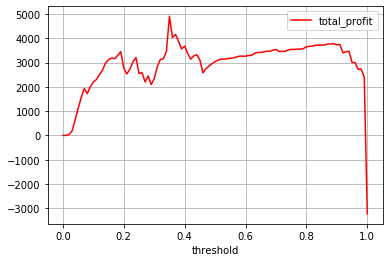

In [56]:
c.plot( kind='line', x='threshold', y='total_profit', color='red', grid=True )

In [58]:
c.iloc[ 30:40, : ]

,threshold,total_profit
30,0.30,2333.38
31,0.31,2823.18
32,0.32,3130.38
33,0.33,3153.22
34,0.34,3466.76
35,0.35,4907.72
36,0.36,4034.56
37,0.37,4161.44
38,0.38,3875.64
39,0.39,3561.82


The maximum profit (€4,908) is achieved with the threshold 0.35.

In [59]:
c.tail( 1 )

,threshold,total_profit
100,1.0,-3232.8


If no action is taken (threshold=1), there is a loss of €3,233.

Total portfolio of the test set:

In [48]:
p.agg( f.sum( 'amount' ) ).show()

+-----------+
|sum(amount)|
+-----------+
|   821250.0|
+-----------+



#### Refit of the Model

In order to be used in production, the model should be refitted on the full data (without the filter "test = false") with the parameters of neural network identified above.<br>
<br>
This also includes:<br>
- scaling
- encoding categorical variables with large number of categories
- balancing classes

In [89]:
sc.stop()

#### Conclusion

The net impact of the model is €8,141 (€4,908 + €3,233).<br>
<br>
Ratio of the net impact to the portfolio:<br>
<b>(€8,141 / €821,250) = 1.0%

So the model turns an unprofitable by default process into profitable one. Amount of saving corresponds to 1% of the entire turnover.